##### Note 
Note that there is a python version that creates the csv files of this document, to save time 

In [21]:
import sys

sys.path.append('../../../common_code')
from PostProcessingScripts import * 
from formation_channels import * 
import astropy.stats

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########
# define colors for formation channels 
channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

channelColorDict_lighter = {'classic':adjust_lightness(color='#118AB2', amount=1.6),'stable B no CEE':adjust_lightness(color='orange', amount=1.4), 'immediate CE':adjust_lightness(color='#EF476F', amount=1.2),\
                            r'double-core CE':adjust_lightness(color='#073B4C', amount=1.8), 'other':adjust_lightness(color='gray', amount=1.5),  'vi':adjust_lightness(color='cyan', amount=1.5), 'vii':adjust_lightness(color='#FFD166', amount=1.2)}
channelList = ['classic', 'stable B no CEE', 'vii',  'immediate CE',  r'double-core CE', 'other'] #, 'vi']
#######

import pandas as pd
from pathlib import Path

In [18]:
def obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/'):
    BPSmodelName='B'
    DCOtype='BNS'
    path_ = '/Volumes/SimonsFoundation/DataDCO/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(path, 'r')
    redshifts = fdata['redshifts']['redshift'][...].squeeze()
    fdata.close()
    return redshifts 





adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run 
print('available redshifts:', redshifts_runs) 

print(MSSFRnameslist)

available redshifts: [0.19230769 0.57692308 0.96153846 1.34615385 1.73076923 2.11538462
 2.5        2.88461538 3.26923077 3.65384615 4.03846154 4.42307692
 4.80769231 5.19230769 5.57692308 5.96153846 6.34615385 6.73076923
 7.11538462 7.5        7.88461538 8.26923077 8.65384615 9.03846154
 9.42307692 9.80769231]
['000', '111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233', '311', '312', '313', '321', '322', '323', '331', '332', '333']


at xparam  mass_tot
at BPS model  C
at DCOtype = BHNS


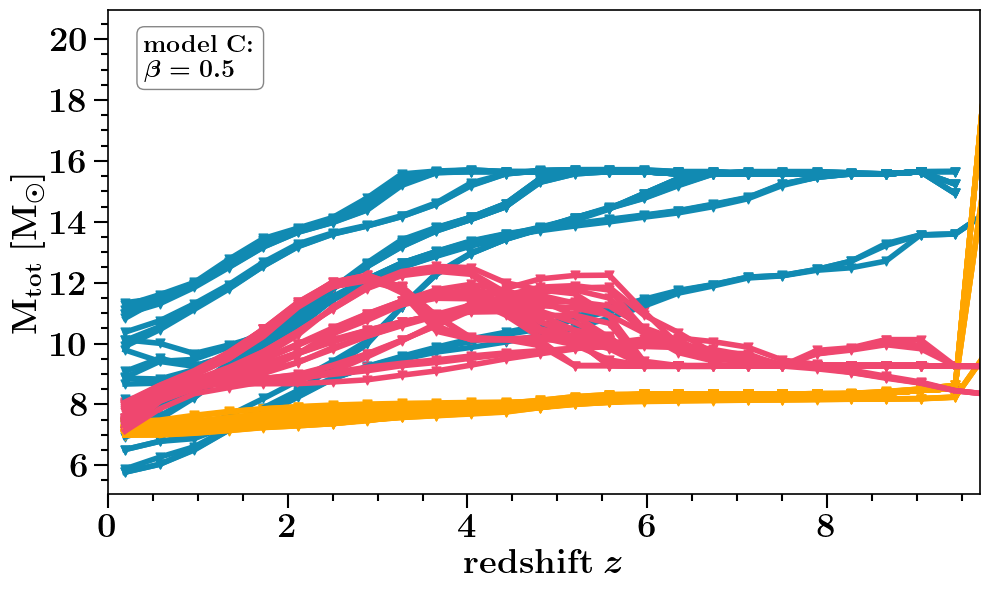


at BPS model  D
at DCOtype = BHNS


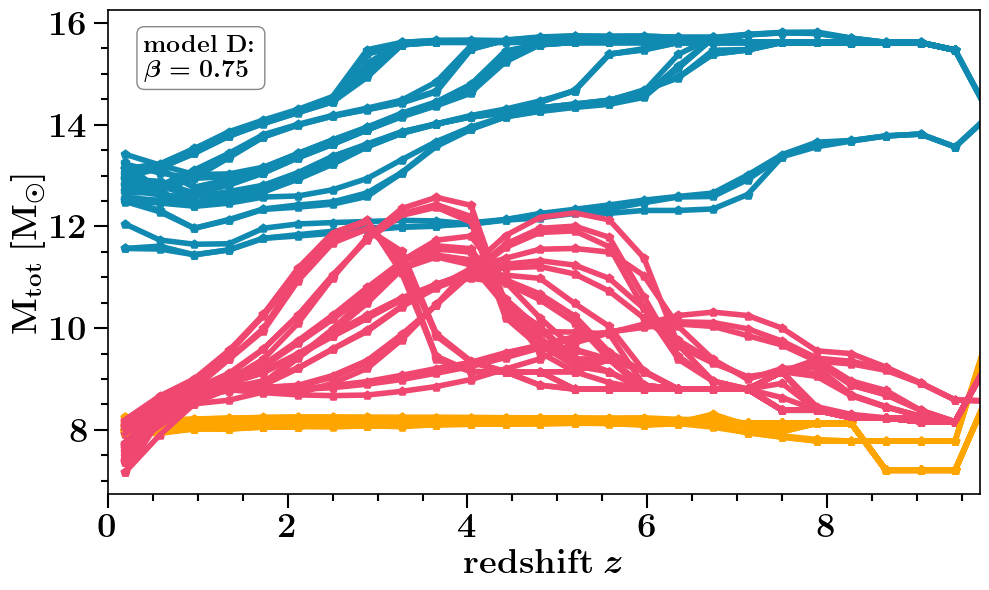


at BPS model  E
at DCOtype = BHNS


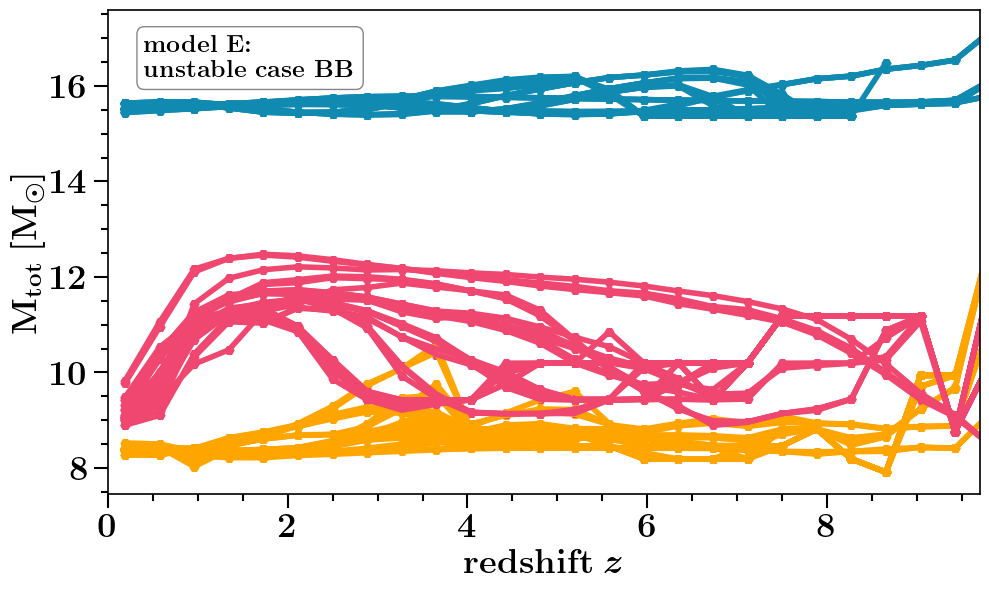


at BPS model  F
at DCOtype = BHNS


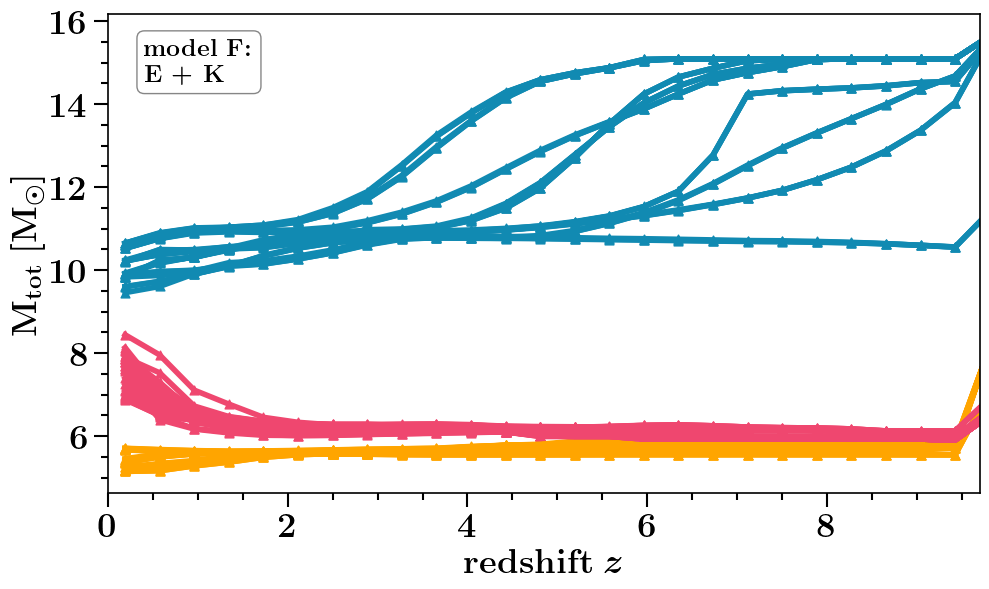


at BPS model  G
at DCOtype = BHNS


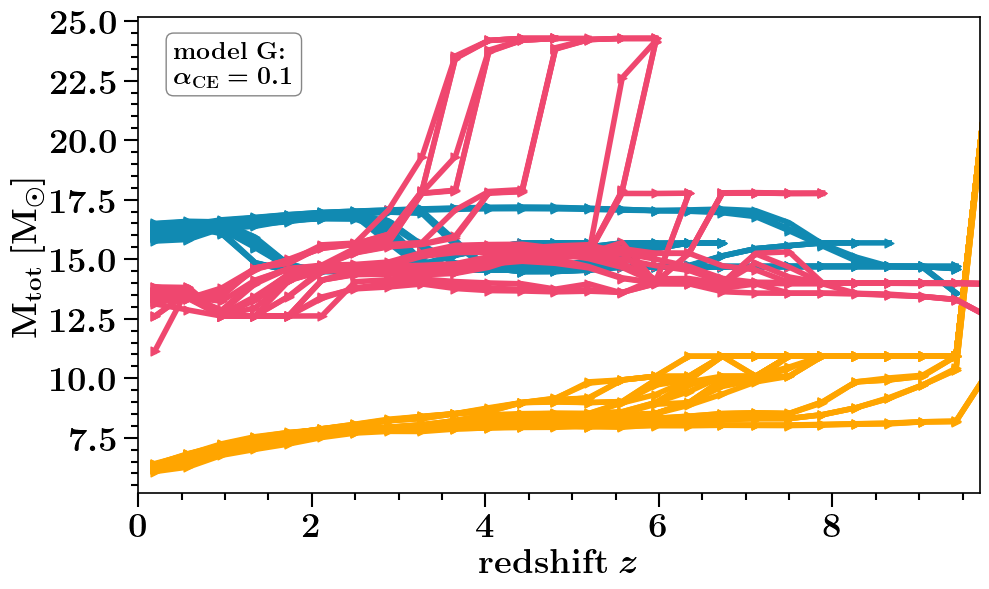


at BPS model  H
at DCOtype = BHNS


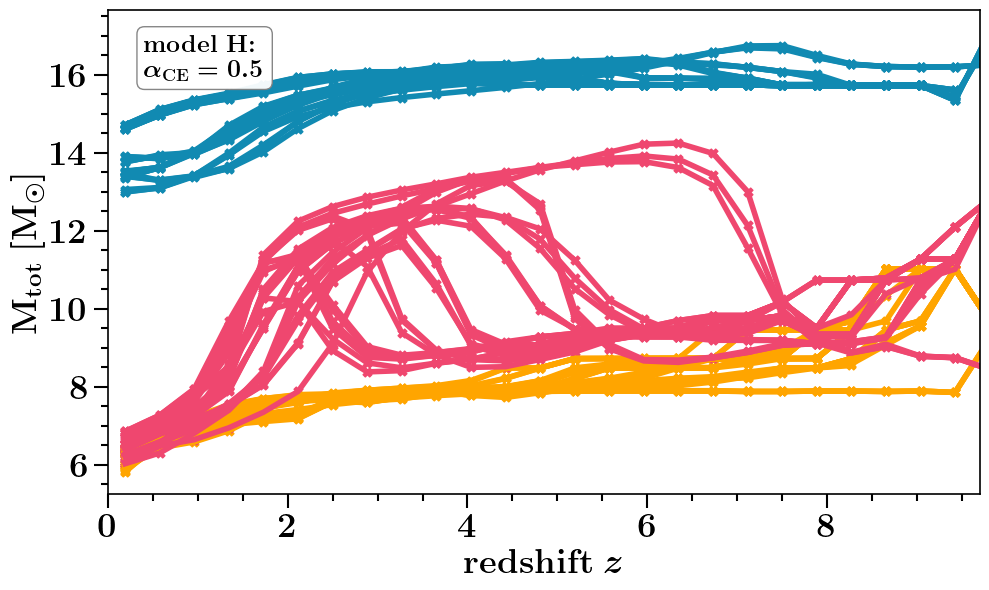


at BPS model  I
at DCOtype = BHNS


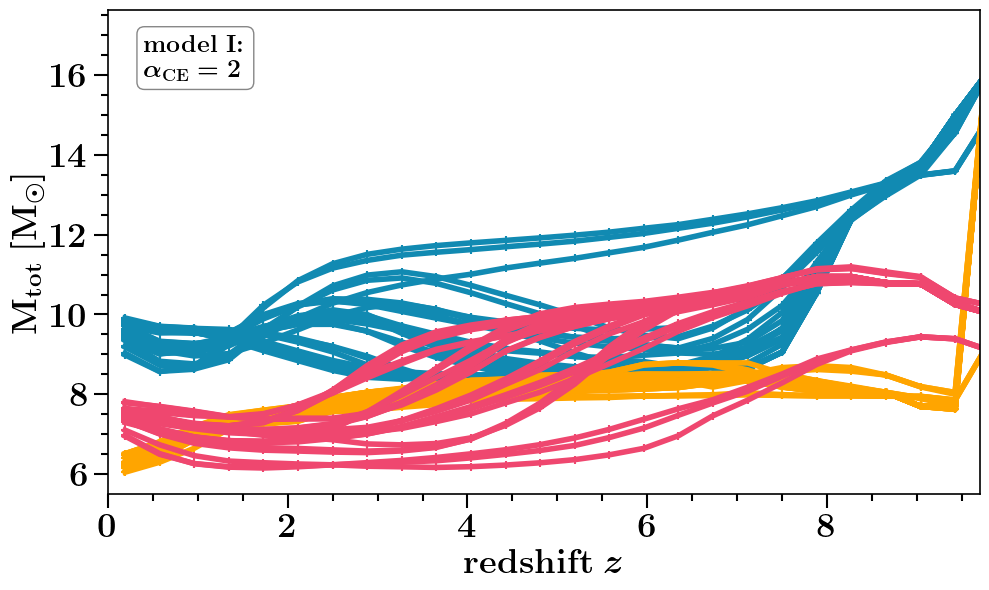


at BPS model  J
at DCOtype = BHNS


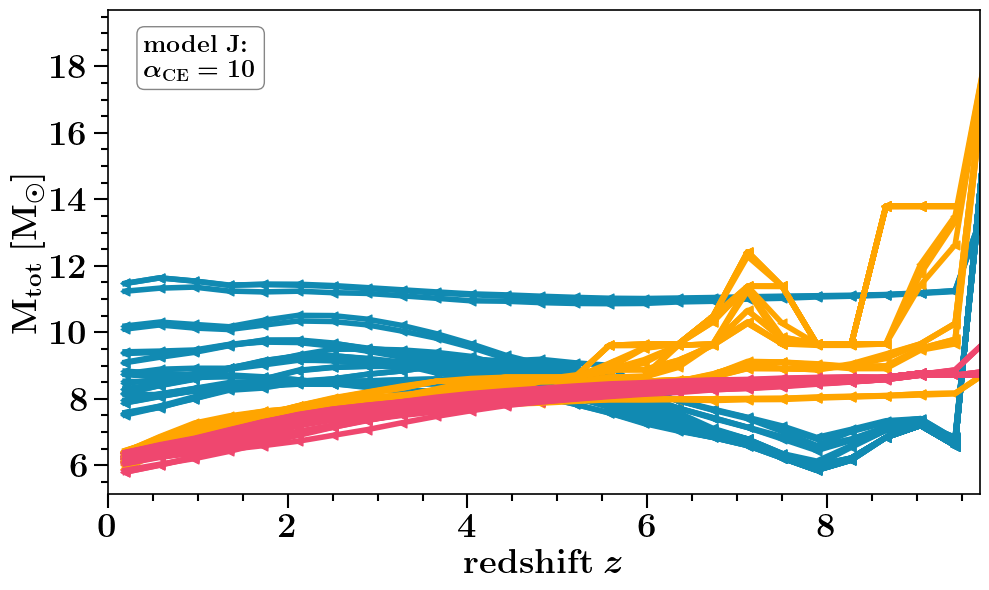


at BPS model  K
at DCOtype = BHNS


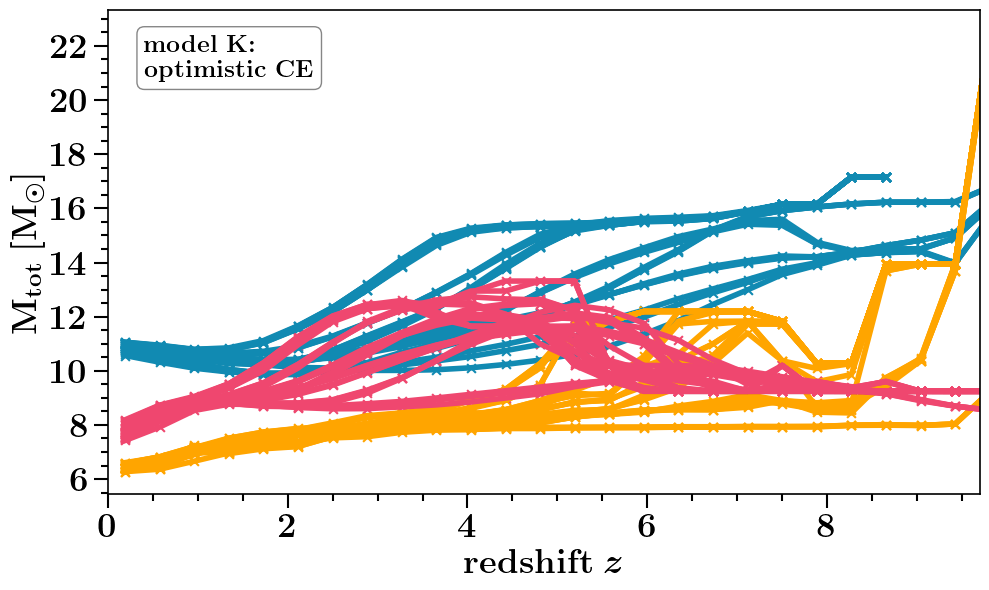


at BPS model  L
at DCOtype = BHNS


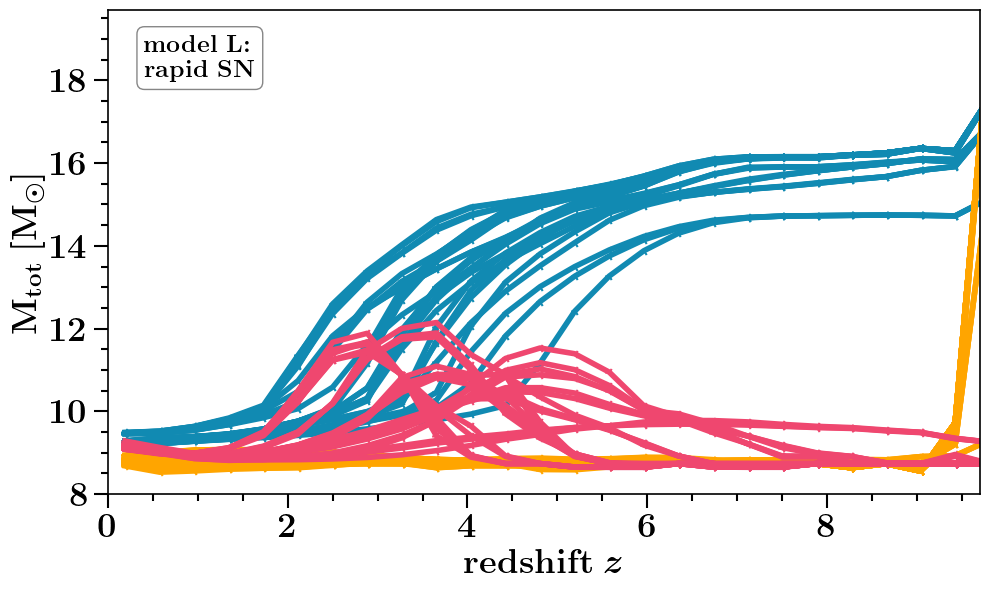


at BPS model  M
at DCOtype = BHNS


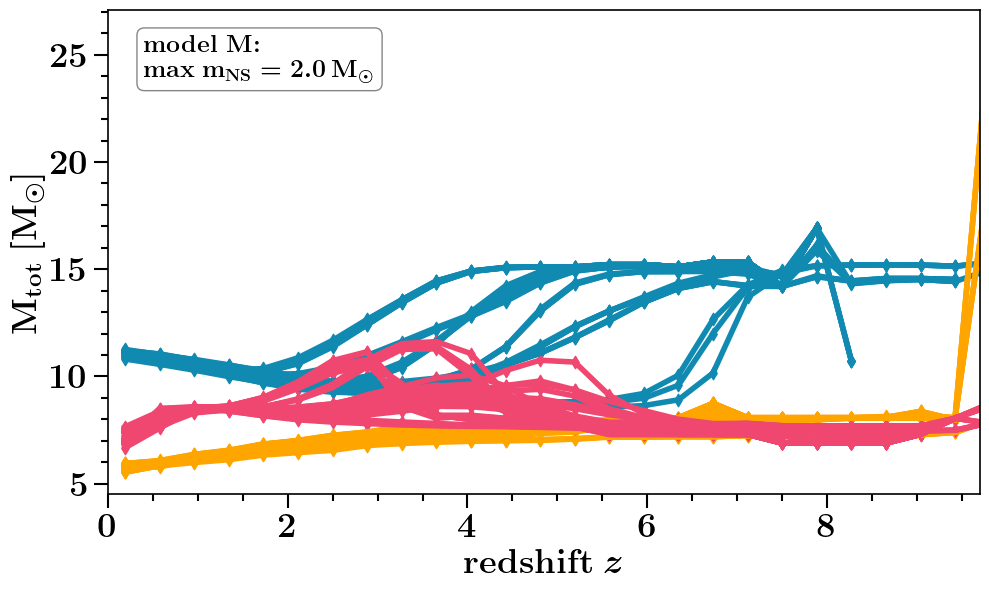


at BPS model  N
at DCOtype = BHNS


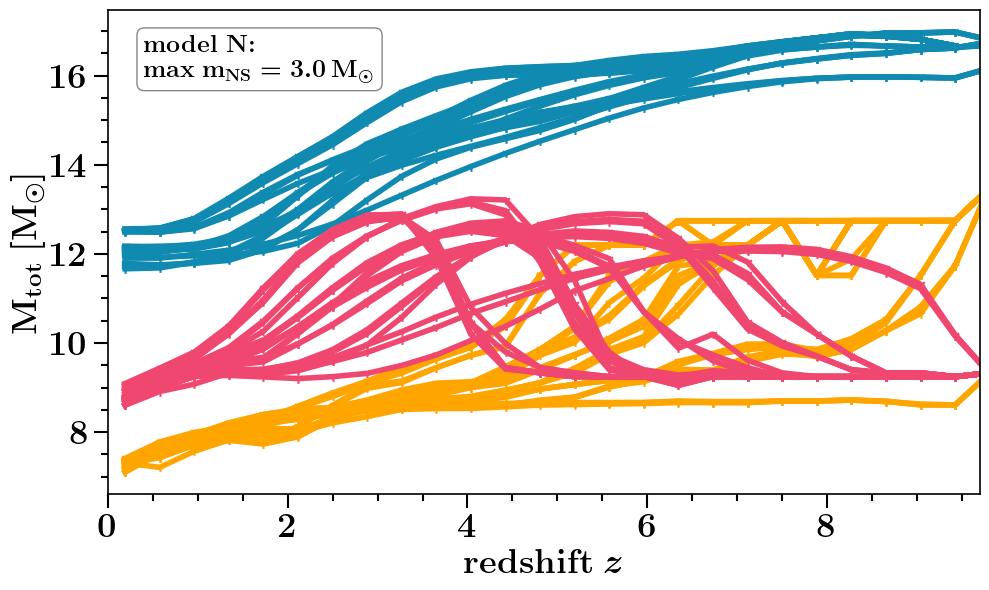


at BPS model  O
at DCOtype = BHNS


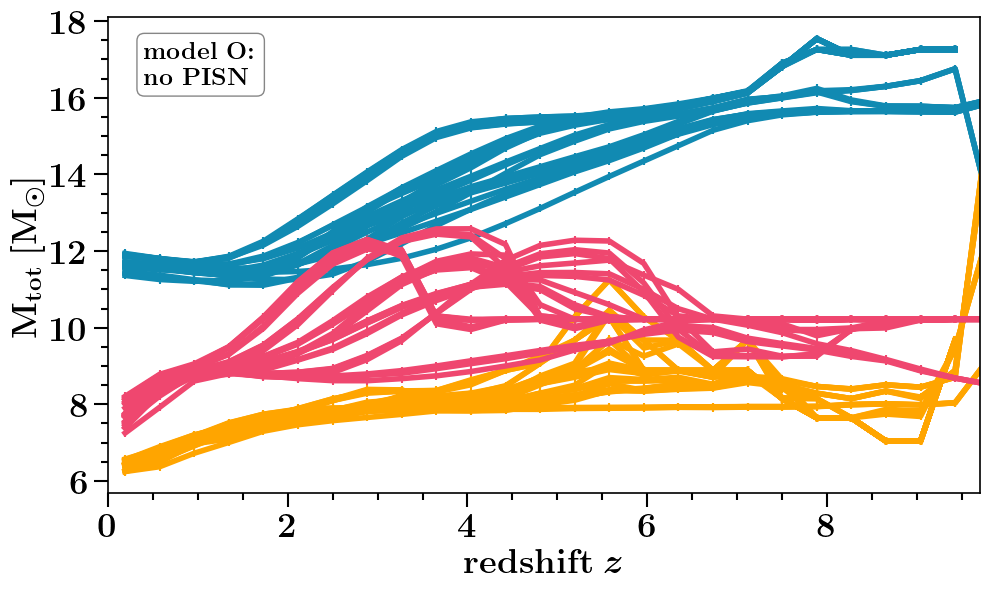


at BPS model  P
at DCOtype = BHNS


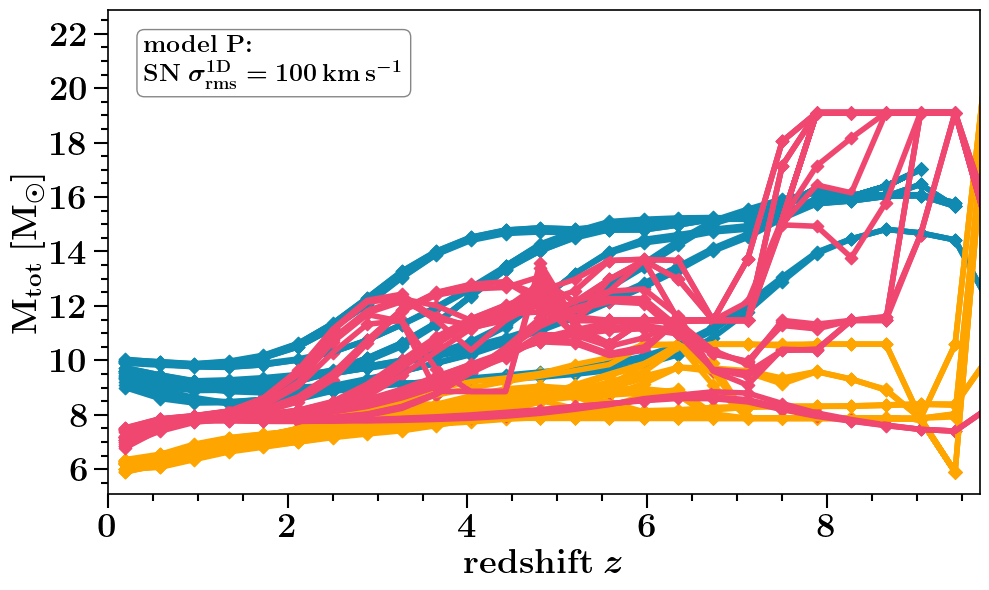


at BPS model  Q
at DCOtype = BHNS


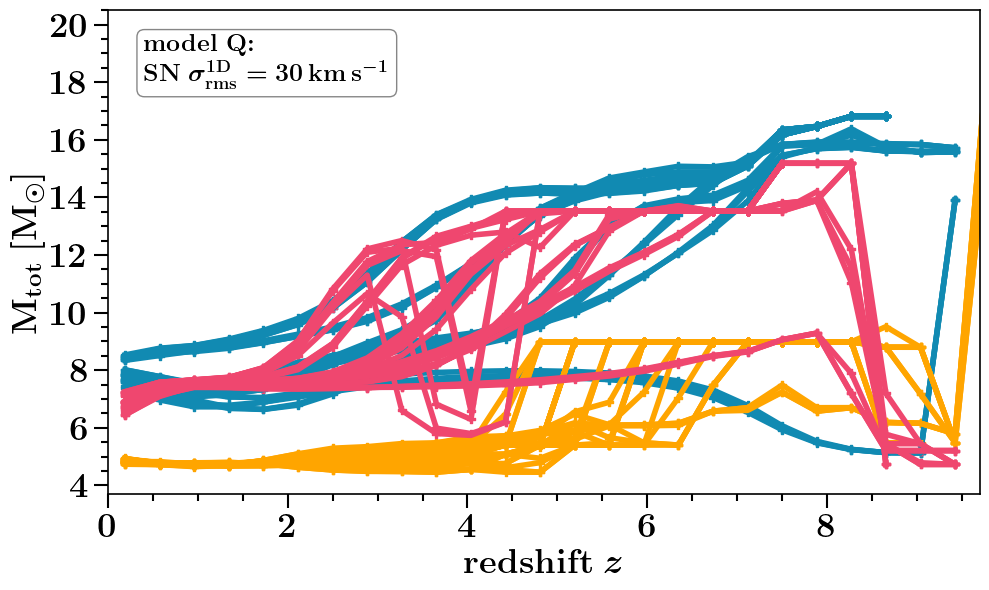


at BPS model  R
at DCOtype = BHNS


In [ ]:


def create_pd_redshift_from_xparam(DCOtype='BHNS', BPSmodelName='A', pathData='/Volumes/SimonsFoundation/DataDCO/', quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay', weights_type='merger', pd_file_path='path_to_pd_file_to_create'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run    
    adjustedChannelList, DCOname = dict_channel_list[DCOtype], DCOname_dict[DCOtype]

    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'     # path for files 
    fdata = h5.File(full_data_path,'r')     # read in data 
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    # make this a dictionary instead !!
    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    elif xparam=='M1ZAMS':
        param_x = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    elif xparam=='M2ZAMS':
        param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    elif xparam=='qZAMS':
        param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze() / fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    elif xparam=='separationInitial':
        param_x = fdata['doubleCompactObjects']['separationInitial'][...].squeeze()


    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    
    
    nZ = len(redshifts_runs)
    fc_data = np.zeros((nZ, 1)) # create empty dataset for redshifts 
    fc_data[:,0] = np.round(redshifts_runs,4)  # fill with redshift data rounded to 4 digits 
    df = pd.DataFrame(fc_data, columns=["redshift"])

    # HERE 

            
            
    
    for nrC, Channel in enumerate(adjustedChannelList): 
        # obtain fc_mask for the requested channel name 
        ind_wanted = dictFormationChannelIndex[Channel]
        mask_MRR = (channels==ind_wanted)
        
        
        for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:]):

            median_at_redshifts = np.zeros_like(redshifts_runs)

            

            data_to_add = np.zeros((nZ, len(quantile_values)))
            data_to_add[:] = np.nan # start with nan values so that we do not plot datapoint if it doesnt exist 
            column_names = [Channel + 'xyz_' + mssfr+ ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 
            
            
            for z_ind, redshift in enumerate(redshifts_runs[0:]):
                redshift = np.round(redshift,4)
      
    
                if weights_type=='merger':
                    fparam_key = 'weights_intrinsicPerRedshift'
                    weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()
                elif weights_type=='formation':
                    fparam_key = "weights_intrinsicFormationPerRedshift"
                    weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()    
    
                # we do not care about the very small rates, keep those to zero (nan)
                if np.sum(weights_[mask_MRR])>1E-6: 
                    data_to_add[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=quantile_values, sample_weight=weights_[mask_MRR])

            df_to_add = pd.DataFrame(data_to_add, columns=column_names)
            df = pd.concat([df, df_to_add], axis=1)

    # always close the dataset
    fdata.close()
    
    
    df.to_csv(pd_file_path)

    return df




def plot_xparam_formation_channels_redshift_for_quantiles(axe='None', DCOtype='BHNS', BPS_models_to_run_list=['A'], 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True, quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay' , weights_type='merger', single_model=True, create_df_file=True):
    
    
    
    adjustedChannelList, DCOname = dict_channel_list[DCOtype], DCOname_dict[DCOtype]
    
    
    pd_file_path = './formation_median/'+ xparam_wanted + '_' + DCOtype + '_' + DCOtype + '_' + xparam_wanted + '_w_' + weights_type + '.csv'
    for ind_bps, BPSmodelName in enumerate(BPS_models_to_run_list):
        if create_df_file==True: df = create_pd_redshift_from_xparam(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, xparam=xparam, weights_type=weights_type, pd_file_path=pd_file_path)
        else: df = pd.read_csv(pd_file_path)
        redshifts = df["redshift"]
        
        

        # plot the channel 
        for nrC, Channel in enumerate(adjustedChannelList): 
            
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:]):
            
                c_FC = channelColorDict[Channel]
                colors_lighter_FC =  channelColorDict_lighter[Channel]

                column_names = [Channel + 'xyz_' + mssfr+ ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 
                qvalues = [df[column_names[i]] for i in range(len(quantile_values))]

                axe.scatter((redshifts), qvalues[0].values, color=c_FC, marker=dictMarkerShape[BPSmodelName], s=40) #/norm_classic_tdelay
                axe.plot(   (redshifts), qvalues[0].values, color=c_FC, lw=4) #, ls=linestyles_mssfrind[ind_mssfr_zind])

#                 axe.fill_between((redshifts), y1=qvalues[1], y2=qvalues[0], color=colors_lighter_FC, alpha=0.5)
#                 axe.fill_between((redshifts), y1=qvalues[0], y2=qvalues[2], color=colors_lighter_FC, alpha=0.5)

#                 axe.fill_between((redshifts), y1=qvalues[3], y2=qvalues[1], color=colors_lighter_FC, alpha=0.2)
#                 axe.fill_between((redshifts), y1=qvalues[2], y2=qvalues[4], color=colors_lighter_FC, alpha=0.2)



    xlabel = r'\textbf{redshift} $z$'
    
    if xparam=='chirp_mass_LVK':
        ylabel = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
    elif xparam=='mass_tot':
        ylabel = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
    elif xparam=='mass_ratio_LVK':
        ylabel = r'$q$'
    elif xparam=='mass_1_LVK':
        ylabel = r'$m_1 [M_{\odot}]$'
    elif xparam=='mass_2_LVK':
        ylabel = r'$m_2 [M_{\odot}]$'
    elif xparam=='log10_t_delay':
        ylabel = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
    elif xparam=='t_delay':
        ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
    elif xparam=='M1ZAMS':
        ylabel = r'$\rm{M}_{\rm{ZAMS, 1}} \ [M_{\odot}]$'
    elif xparam=='M2ZAMS':
        ylabel = r'$\rm{M}_{\rm{ZAMS, 2}} \ [M_{\odot}]$'
    elif xparam=='qZAMS':
        ylabel = r'${q}_{\rm{ZAMS}} $'
    elif xparam=='separationInitial':
        ylabel = r'${a}_{\rm{ZAMS}} [\rm{AU}] $'      
    

    # axes properties 
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)
    axe.set_xlim(0,9.7)  # redshift range 
    if xparam in ['t_delay', 'separationInitial']:
        axe.set_yscale('log')
    
    ## add label in a legend for plot 
    if single_model==True: annotate_label = r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName]
    else: annotate_label = r'\textbf{%s}'%(DCOtype)        
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(annotate_label, xy=(0.042, .95), xycoords='axes fraction', fontsize = fs-6, weight = 'bold', ha='left', va="top",bbox=bbox_props, zorder=100)             
            
            
            
    return axe








################ CHANGE THE THINGS BELOW ################
quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9 ]
DCOTypeList = ['BHNS'] #, https://arxiv.org/pdf/2402.00935.pdf
whichQuantity = 'median'
pathData='/Volumes/SimonsFoundation/DataDCO/'
single_model=True
boot_strap_uncertainties=False # True 
only_channels_with_min_contribution = 0.01 # percent
dict_channel_list = {'BBH':['classic', 'stable B no CEE'],\
                     'BHNS':['classic', 'stable B no CEE', 'immediate CE'],\
                     'BNS':['classic', r'double-core CE', 'other'] } 
weights_type='merger'
create_df_file = True
###########################################################




# for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK','qZAMS', 'separationInitial']:
for xparam_wanted in [ 'mass_tot']: #, 'M1ZAMS', 'M2ZAMS']:
    print('at xparam ', xparam_wanted)
    
    if single_model==True:enumerate_list = BPSnameslist[2:]
    else: enumerate_list = [0]
    for ind_m, BPSmodelName in  enumerate(enumerate_list):
        if single_model==True:
            BPS_models_to_run_list=[BPSmodelName]
            print('at BPS model ', BPSmodelName)
            save_fig_string = BPSmodelName
        else: 
            BPS_models_to_run_list = BPSnameslist
            save_fig_string = 'all'
            
        for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
            print('at DCOtype =', DCOtype)


            ncols, nrows= 1,1
            f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})

            ax = plot_xparam_formation_channels_redshift_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
                                                                  pathData=pathData,  single_model=single_model, quantile_values=quantile_values,\
                                                                               xparam=xparam_wanted, weights_type=weights_type, create_df_file=create_df_file) 


            
            ##  SAVE FIG  ###
            plt.tight_layout()
            plt.subplots_adjust(wspace=0., hspace=0.18)  
            plt.savefig('./formation_median/'+ xparam_wanted + '/zQuantile_' +  DCOtype + '_' + save_fig_string + '_' + xparam_wanted + '_w_' + weights_type + '.png', transparent=False, dpi=300)
            plt.show()
            plt.close()
            print()













In [4]:
# def plot_formation_channels_metallicity_from_xparam_for_quantiles(axe='None', DCOtype='BHNS', BPS_models_to_run_list=['A'], 
#                                                   pathData='/Volumes/SimonsFoundation/DataDCO/',\
#                                                 mask_specific_mssfr=None,\
#                                                 whichQuantity='median', value_for_fraction=False, \
#                                               add_model_label=True, quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay'):
    
# #     print('running xparam:', xparam)
# #     print()
    
    
    
#     if DCOtype=='BBH':
#         adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
#     elif DCOtype=='BHNS':
#         adjustedChannelList = ['classic', 'stable B no CEE', 'immediate CE'] #,  r'double-core CE', 'other']
#     if DCOtype=='BNS':
#         adjustedChannelList = ['classic',   r'double-core CE'] #, 'other']
#     print('running for channels', adjustedChannelList)
# #     adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']

#     for ind_bps, BPSmodelName in enumerate(BPS_models_to_run_list):
#         df = create_pd_metallicity_from_xparam(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, xparam=xparam)
#         metallicities = df["metallicity"]
        
        
# #         norm_classic_tdelay = df['classic q_0.5'].values
# #         print('median ref time; ', norm_classic_tdelay)
#         # plot the channel 
#         for nrC, Channel in enumerate(adjustedChannelList): 
#             c_FC = channelColorDict[Channel]
#             colors_lighter_FC =  channelColorDict_lighter[Channel]
            
#             column_names = [Channel + ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 
#             qvalues = [df[column_names[i]] for i in range(len(quantile_values))]
            
#             axe.scatter(np.log10(metallicities), qvalues[0].values, color=c_FC, marker=dictMarkerShape[BPSmodelName], s=40) #/norm_classic_tdelay
#             axe.plot(   np.log10(metallicities), qvalues[0].values, color=c_FC, lw=4) #, ls=linestyles_mssfrind[ind_mssfr_zind])
            
#             axe.fill_between(np.log10(metallicities), y1=qvalues[1], y2=qvalues[0], color=colors_lighter_FC, alpha=0.5)
#             axe.fill_between(np.log10(metallicities), y1=qvalues[0], y2=qvalues[2], color=colors_lighter_FC, alpha=0.5)
            
#             axe.fill_between(np.log10(metallicities), y1=qvalues[3], y2=qvalues[1], color=colors_lighter_FC, alpha=0.2)
#             axe.fill_between(np.log10(metallicities), y1=qvalues[2], y2=qvalues[4], color=colors_lighter_FC, alpha=0.2)
    
    

#     xlabel = r'$\log_{10}$ \textbf{Metallicity} $Z$'
    
#     if xparam=='chirp_mass_LVK':
#         ylabel = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
#     elif xparam=='mass_tot':
#         ylabel = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
#     elif xparam=='mass_ratio_LVK':
#         ylabel = r'$q$'
#     elif xparam=='mass_1_LVK':
#         ylabel = r'$m_1 [M_{\odot}]$'
#     elif xparam=='mass_2_LVK':
#         ylabel = r'$m_2 [M_{\odot}]$'
#     elif xparam=='log10_t_delay':
#         ylabel = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
#     elif xparam=='t_delay':
#         ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
#     elif xparam=='M1ZAMS':
#         ylabel = r'$\rm{M}_{\rm{ZAMS, 1}} \ [M_{\odot}]$'
#     elif xparam=='M2ZAMS':
#         ylabel = r'$\rm{M}_{\rm{ZAMS, 2}} \ [M_{\odot}]$'
#     elif xparam=='qZAMS':
#         ylabel = r'${q}_{\rm{ZAMS}} $'
#     elif xparam=='separationInitial':
#         ylabel = r'${a}_{\rm{ZAMS}} [\rm{AU}] $'      
    
# #     ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
    
#     axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)
#     # set metallicity range
#     axe.set_xlim(-4,-1.7)
    
#     if xparam in ['t_delay', 'separationInitial']:
#         axe.set_yscale('log')
    
    
#     bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#     axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
#                  xycoords='axes fraction', fontsize = fs-6, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
#                 zorder=1E10)  
# #     bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
# #     axe.annotate(r'\textbf{%s}'%(DCOtype), xy=(0.042, .95),\
# #                  xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
# #                 zorder=1E10)
            
            
#     return axe




# ###
# quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9 ]
# DCOTypeList = ['BBH', 'BHNS', 'BNS']
# whichQuantity = 'median'
# ###


# # for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK',]:
# for xparam_wanted in [ 'qZAMS', 'separationInitial']: #, 'M1ZAMS', 'M2ZAMS']:
#     print('at xparam ', xparam_wanted)
#     for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#         print('at BPS model ', BPSmodelName)
#         BPS_models_to_run_list=[BPSmodelName]
#     #     BPS_models_to_run_list = BPSnameslist
#         for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
#             print('at DCOtype =', DCOtype)


#             ncols, nrows= 1,1
#             f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), 
#                           gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



#             ax = plot_formation_channels_metallicity_from_xparam_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
#                                                                   pathData=pathData,mask_specific_mssfr=None, whichQuantity=whichQuantity, value_for_fraction=False, \
#                                                                                add_model_label=True, quantile_values=quantile_values, xparam=xparam_wanted) 





#             ##  SAVE FIG  ###
#             plt.tight_layout()
#             plt.subplots_adjust(wspace=0., hspace=0.18)  
#             plt.savefig('./formation_median/'+ xparam + '/MetallicityQuantile_' +  DCOtype + '_' + BPSmodelName + '_' + xparam + '.png', transparent=False, dpi=300)
# #             plt.savefig('./formation_median/'+ xparam + '/MetallicityQuantile_' +  DCOtype + '_' + BPSmodelName + '_' + xparam + '.pdf', transparent=True)
#             plt.show()
#             plt.close()
#             print()



In [7]:
! pwd

/Users/floorbroekgaarden/Projects/GitHub/DCO_FormationChannels/plottingCode/Figure_Redshift_Rates


## ENDS HERE ## 
GO TO other jupyter notebook (in same folder) for the working/most recent version of code as a function of metallicity 

In [ ]:
def plot_total_quantiles_redshift(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', xparam='mass_tot', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    
    
    for ind_m, BPSmodelName in  enumerate(BPSnameslist[0:]):
        print(BPSmodelName)
        color_m = colorDirDict[BPSmodelName]
    
        # path for files 
        full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(full_data_path,'r')

        # get the delay time in Gyr 


        massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
        massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
        # M1 will be the most massive, M2 the least massive compact object. 
        massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

        if xparam=='chirp_mass_LVK':
            param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
            nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(1,100,1000)
        elif xparam=='mass_tot':
            param_x = massCO_LVKM1 + massCO_LVKM2
            nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(1,5,1000)
        elif xparam=='mass_ratio_LVK':
            param_x = MassRatioCO_LVK
            nameX = r'$q$'
            nameY = r'\textbf{PDF}'
            xx = np.linspace(-0.2,1.2,1000)
        elif xparam=='mass_1_LVK':
            param_x = massCO_LVKM1
            nameX = r'$m_1 [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            if DCOtype=='BBH':
                xx = np.linspace(-1,150,1000) # needs to be a little bit larger
            elif DCOtype=='BHNS':
                xx = np.linspace(-1,50,1000)
            elif DCOtype=='BNS':
                xx = np.linspace(-2,5,500)
        elif xparam=='mass_2_LVK':
            param_x = massCO_LVKM2
            nameX = r'$m_2 [M_{\odot}]$'
            nameY = r'\textbf{PDF}'
            if DCOtype=='BBH':
                xx = np.linspace(-1,150,1000) # needs to be a little bit larger
            elif DCOtype=='BHNS':
                xx = np.linspace(-2,5,1000)
            elif DCOtype=='BNS':
                xx = np.linspace(-2,5,500)

        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)  
            print('obtained params')
        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)  
            print('obtained params')    

        elif xparam=='t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
            nameY = r'\textbf{PDF}'  
            xx = np.linspace(-2.5,2,500)     


        channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()


        print('obtained params')   

        for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:]):

            median_at_redshifts = np.zeros_like(redshifts_runs)

            for z_ind, redshift in enumerate(redshifts_runs[0:]):
                redshift = np.round(redshift,4)

                if weights_type=='merger':
                    fparam_key = 'weights_intrinsicPerRedshift'
                    weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()
                elif weights_type=='formation':
                    fparam_key = "weights_intrinsicFormationPerRedshift"
                    weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()



                if whichQuantity=='median':
                    median_at_redshifts[z_ind] = weighted_quantile(values=param_x, quantiles=[0.5], sample_weight=weights_)
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x <= value_for_fraction
                    median_at_redshifts[z_ind] = np.sum(weights_[mask_systems])/np.sum(weights_)
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction


            axe.scatter(redshifts[:], median_at_redshifts, color=color_m, marker=dictMarkerShape[BPSmodelName])
            axe.plot(redshifts[:],    median_at_redshifts, color=color_m) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
        # always close the dataset
        fdata.close()


        
        
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
    
    #axe.set_ylim(2,3.8)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




In [ ]:
# plot delay times with fraction 

weights_type='formation'
whichQuantity='median'
xparam = 't_delay' #'mass_tot'


for DCOtype in [ 'BNS']:
    print()
    print('at DCOtype =', DCOtype)


    ncols, nrows= 1,1
    f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



    ax = plot_total_quantiles_redshift(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                          redshifts=redshifts_runs, pathData=pathData,\
                                                        c_FC=color_m, mask_specific_mssfr='x',\
                                                     whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                    weights_type=weights_type) 


    ##  SAVE FIG  ###
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.18)  
    plt.savefig('./formation_median/'+xparam+'/'+xparam+'_total_ratesz_' +  DCOtype + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
    plt.savefig('./formation_median/'+xparam+'/'+xparam+'_total_ratesz_' +  DCOtype + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
    plt.show()
    plt.close()

                    
                    

In [ ]:
def plot_formation_channels_quantiles_redshift(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', xparam='mass_tot', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    

    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
        nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,5,1000)
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
        nameX = r'$m_1 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-1,50,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
        nameX = r'$m_2 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-2,5,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
            
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')    
    
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)     
    
    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    
    #     param_x = np.log10(param_x)
    
#     nameY = r'\textbf{PDF}'  
#     xx = np.linspace(1,100,500)  
    print('obtained params')   
    
    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
    
        if np.sum(mask_MRR)>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE
        #     if mask_specific_mssfr==None:
        #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):

                median_at_redshifts = np.zeros_like(redshifts_runs)

                for z_ind, redshift in enumerate(redshifts_runs[0:]):
                    redshift = np.round(redshift,4)
                    
                    if weights_type=='merger':
                        fparam_key = 'weights_intrinsicPerRedshift'
                        weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    elif weights_type=='formation':
                        fparam_key = "weights_intrinsicFormationPerRedshift"
                        weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    
                
#                     fparam_key = "weights_intrinsicFormationPerRedshift"
# #                     fparam_key = 'weights_intrinsicPerRedshift'
#                     weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
#                     weights_ = fdata[fparam_key][weightheader][...].squeeze()



                    if whichQuantity=='median':
                        median_at_redshifts[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=[0.5], sample_weight=weights_[mask_MRR])
                        nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                    elif whichQuantity=='fraction':
                        mask_systems = param_x[mask_MRR] <= value_for_fraction
                        median_at_redshifts[z_ind] = np.sum(weights_[mask_MRR][mask_systems])/np.sum(weights_[mask_MRR])
                        nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

                axe.scatter(redshifts[:], median_at_redshifts, color=c_FC, marker=dictMarkerShape[BPSmodelName])
                axe.plot(redshifts[:],    median_at_redshifts, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
    if xparam in ['mass_tot']:
        axe.set_ylim(2, 4)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




In [ ]:
# ! mkdir ./formation_median/mass_tot

In [ ]:
# plot delay times with fraction 

weights_type='formation'
whichQuantity='median'
xparam = 'mass_tot'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[0:]):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_quantiles_redshift(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x',\
                                                         whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                        weights_type=weights_type) 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

# as a function of metallicity 

In [ ]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          xparam='mass_tot', BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
#     param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
        nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,5,1000)
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
        nameX = r'$m_1 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-1,50,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
        nameX = r'$m_2 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-2,5,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
            
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')    
    
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)         
    
    

    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    median_at_ZZ[ind_Z] = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5], sample_weight=weights_[mask_MRR][mask_ZZ])
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        
        mask_not_zero = (median_at_ZZ!=0)
        axe.scatter(np.log10(np.unique(metallicities))[mask_not_zero], median_at_ZZ[mask_not_zero], color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities))[mask_not_zero],    median_at_ZZ[mask_not_zero], color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)

    if xparam in ['mass_tot']:
        axe.set_ylim(2, 4)        

        
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
            axe.set_ylim(0.001, 2)
    
    
    
#     axe.set_xscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




# plot delay times with fraction 




whichQuantity='median'
xparam = 't_delay'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    



# WORKING CODE 

In [ ]:
def plot_formation_channels_redshift_rate_mssfr(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', redshifts=[0],\
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                  c_FC=False, mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                               weights_type='formation'):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    
    
    param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    
    #     param_x = np.log10(param_x)
    
#     nameY = r'\textbf{PDF}'  
    xx = np.linspace(1,100,500)  
    print('obtained params')   
    
    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
    
        if np.sum(mask_MRR)>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE
        #     if mask_specific_mssfr==None:
        #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):
                print(mssfr)

                median_at_redshifts = np.zeros_like(redshifts_runs)

                for z_ind, redshift in enumerate(redshifts_runs[0:]):
                    redshift = np.round(redshift,4)
                    
                    if weights_type=='merger':
                        fparam_key = 'weights_intrinsicPerRedshift'
                        weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    elif weights_type=='formation':
                        fparam_key = "weights_intrinsicFormationPerRedshift"
                        weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                        weights_ = fdata[fparam_key][weightheader][...].squeeze()
                    
                
#                     fparam_key = "weights_intrinsicFormationPerRedshift"
# #                     fparam_key = 'weights_intrinsicPerRedshift'
#                     weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
#                     weights_ = fdata[fparam_key][weightheader][...].squeeze()



                    if whichQuantity=='median':
                        median_at_redshifts[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=[0.5], sample_weight=weights_[mask_MRR])
                        nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                    elif whichQuantity=='fraction':
                        mask_systems = param_x[mask_MRR] <= value_for_fraction
                        median_at_redshifts[z_ind] = np.sum(weights_[mask_MRR][mask_systems])/np.sum(weights_[mask_MRR])
                        nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

                axe.scatter(redshifts[:], median_at_redshifts, color=c_FC, marker=dictMarkerShape[BPSmodelName])
                axe.plot(redshifts[:],    median_at_redshifts, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'    
    xlabel = r'\textbf{redshift} $z$'
    ylabel = nameY
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
    axe.set_xlim(0,9.6)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        axe.set_yscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




In [ ]:
# plot delay times with fraction 



weights_type='formation'
whichQuantity='median'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[5:]):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BHNS', 'BBH']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_redshift_rate_mssfr(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x',\
                                                         whichQuantity=whichQuantity, value_for_fraction=0.1,\
                                                        weights_type=weights_type) 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.png', transparent=False)
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '_' + weights_type + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

In [ ]:
# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist):
    color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in [ 'BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_redshift_rate_mssfr(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              redshifts=redshifts_runs, pathData=pathData,\
                                                            c_FC=color_m, mask_specific_mssfr='x', whichRate='channeltotal') 


        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '.png', transparent=False)
        plt.savefig('./formation_median/delay_time/delay_time_ratesz_' +  DCOtype + '_' + BPSmodelName + '.pdf', transparent=False)
        plt.show()
        plt.close()


In [ ]:
DCOtype='BNS'



pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
DCOname = DCOname_dict[DCOtype]





for ind_bps, BPSmodelName in enumerate(BPSnameslist):
    
    ncols, nrows= 1,1
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(full_data_path,'r')

    # get the redshifts
    redshifts = redshifts_runs


    for ind_mssfr, mssfr in enumerate([MSSFRnameslist[1]]):
#     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:2]):
        print('mssfr', mssfr)

        rates_at_redshifts = np.zeros_like(redshifts_runs)
        rates_at_redshifts_form = np.zeros_like(redshifts_runs)


        for z_ind, redshift in enumerate(redshifts_runs[0:]):
            print(redshift)
            redshift = np.round(redshift,4)
            fparam_key = "weights_intrinsicFormationPerRedshift"

            weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
            weights_form = fdata[fparam_key][weightheader][...].squeeze()

            fparam_key = 'weights_intrinsicPerRedshift'
            weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
            weights_ = fdata[fparam_key][weightheader][...].squeeze()

            rates_at_redshifts[z_ind] = np.sum(weights_)
            rates_at_redshifts_form[z_ind] = np.sum(weights_form)

        axe.scatter(redshifts[:], rates_at_redshifts, color='blue')
        axe.plot(redshifts[:],    rates_at_redshifts, color='blue') #, ls=linestyles_mssfrind[ind_mssfr_zind])

        axe.scatter(redshifts[:], rates_at_redshifts_form, color='orange')
        axe.plot(redshifts[:],    rates_at_redshifts_form, color='orange') #, ls=linestyles_mssfrind[ind_mssfr_zind])

        
        
        
        
    axe.set_yscale('log')
        
    plt.show()
    fdata.close()


In [ ]:
fdata.close()

In [ ]:
DCOtype='BNS'



pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
DCOname = DCOname_dict[DCOtype]


for BPSmodelName in BPSnameslist[0:3]:


    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    # read in data 
    fdata = h5.File(full_data_path,'r')
    print()
    print('BPS ' , BPSmodelName)
    
    
    print(fdata['weights_intrinsicFormationPerRedshift'].keys())

    fdata.close()







In [ ]:
MassEvolved = [77598406.21327497, 77598095.82151248, 77598483.8112156, 77598018.22357185
, 77598328.61533435, 77598483.8112156, 77598483.8112156, 77598018.22357185
, 77598095.82151248, 77598483.8112156, 77598561.40915622, 77598173.4194531
, 77598328.61533435, 77598561.40915622, 77598483.8112156, 77598406.21327497
, 77598095.82151248, 77598018.22357185, 77598406.21327497, 77598639.00709686
, 77598639.00709686, 77598406.21327497, 77598639.00709686, 77598483.8112156
, 77598483.8112156, 77598095.82151248, 77598251.01739372, 77598483.8112156
, 77598483.8112156, 77598251.01739372, 77598173.4194531, 77597940.62563121
, 77598251.01739372, 77598483.8112156, 77598095.82151248, 77598561.40915622
, 77598173.4194531, 77598328.61533435, 77598561.40915622, 77598406.21327497
, 77598173.4194531, 77598406.21327497, 77598173.4194531, 77598251.01739372
, 77598173.4194531, 77598095.82151248, 77597940.62563121, 77598095.82151248
, 77598406.21327497, 77598561.40915622, 77598639.00709686, 77598173.4194531
, 77598095.82151248]

print(np.mean(MassEvolved))
print(np.median(MassEvolved))

In [ ]:
xx = np.linspace(0,1,10000)

quantiles = weighted_quantile(values=xx, quantiles=[0.5, 0.25, 0.75])
print(quantiles)

In [ ]:


quantiles=[0.5, 0.25, 0.75]
metallicities = np.asarray([0.1, 0.8, 0.3, 0.4])
# del empty_data

print(df)

In [ ]:

A = np.zeros((4, 1))
print(A)
print(A[:,0])
A[:,0] = metallicities
print(A)

In [ ]:
A = np.zeros((3,4))
A[:] = np.nan
print(A)

print(A[0])

## Plot median delay times as a function of metallicity

In [ ]:









def plot_formation_channels_metallicity_xparam_for_quantiles(axe='None', DCOtype='BHNS', BPSmodelNameList=['A'], 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True, quantile_values=[0.5, 0.25, 0.75]):
    
    
    for BPSmodelName in enumerate(BPSmodelNameList):
        df = create_pd_metallicity_xparam(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype)
        metallicities = df["metallicity"]
        
        # plot the channel 
        for nrC, Channel in enumerate(adjustedChannelList): 
            c_FC = channelColorDict[Channel]
            colors_lighter_FC =  channelColorDict_lighter[Channel]
            
            column_names = [Channel + ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 
            qvalues = [df[column_names[i]] for i in range(len(quantile_values))]
            
            axe.scatter(np.log10(metallicities), qvalues[0], color=c_FC, marker=dictMarkerShape[BPSmodelName])
            axe.plot(   np.log10(metallicities), qvalues[0], color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])

            
    return axe


###
quantile_values=[0.5, 0.25, 0.75]
DCOTypeList = ['BHNS']
whichQuantity = 'median'
###

for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)
    BPSmodelNameList=[BPSmodelName_temp]
    for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)


        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam_for_quantiles(axe=ax, DCOtype=DCOtype, BPSmodelNameList=BPSmodelNameList,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=True, quantile_values=quantile_values) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()



## I am working here :) 

In [ ]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other'
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    quantiles = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5, 0.25, 0.75], sample_weight=weights_[mask_MRR][mask_ZZ])
                    median_at_ZZ[ind_Z] = quantiles[0] # first requested value is the median
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

        axe.scatter(np.log10(np.unique(metallicities)), median_at_ZZ, color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities)),    median_at_ZZ, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameY
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        axe.set_yscale('log')
    
#     axe.set_xscale('log')
    
    if add_model_label==True:
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
        axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                     xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                    zorder=1E10)

    return axe




In [ ]:
# plot delay times with fraction 




whichQuantity='median'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=True) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

## all in one figure 

In [ ]:
whichQuantity='median'
ncols, nrows= 1,1
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)





        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=False) 



        
        
##  SAVE FIG  ###
plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.18)  
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.png', transparent=False, dpi=300)
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:
Change the above to include and go to zero if metallicity doesnt exist. 